In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2025/sample_submission.json
/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json


**Setup & Instalasi**

In [44]:
!pip install networkx tqdm

In [45]:
# 1) Import library dasar
import os
import json
import numpy as np
import torch
import random

# 2) Pastikan reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 3) Cek perangkat (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 4) Path data
DATA_DIR = '/kaggle/input/arc-prize-2025'

# 5) (Opsional) Install dependensi tambahan
#    Kaggle image container sudah menyertakan PyTorch, NumPy, dll.
#    Jika butuh library lain, uncomment dan sesuaikan:


# 6) Buat direktori kerja untuk output/model
WORK_DIR = '/kaggle/working'
os.makedirs(WORK_DIR, exist_ok=True)


Using device: cuda


# Eksplorasi Data (EDA) 

Loaded 1000 tasks from /kaggle/input/arc-prize-2025/arc-agi_training_challenges.json
=== Frequent Basic Ops ===
             count
other         3196
identity        10
rot180           8
flip_h           5
flip_v           4
rot90            4
shift(-1,1)      2
fill(5)          2
fill(2)          1

=== Top-10 Color Mappings (old→new) ===
  (old→new)  count
0    (0, 3)   9558
1    (0, 2)   7341
2    (0, 8)   5794
3    (0, 4)   4890
4    (0, 1)   4524
5    (0, 7)   2179
6    (0, 6)   1851
7    (0, 5)   1541
8    (1, 2)   1123
9    (3, 0)   1103

=== Region Counts Description ===
       in_regions  out_regions
count      2114.0       2114.0
mean          1.0          1.0
std           0.0          0.0
min           1.0          1.0
25%           1.0          1.0
50%           1.0          1.0
75%           1.0          1.0
max           1.0          1.0

=== Bounding-Box Shift Stats ===
            dx        dy
mean  0.241136  0.178076
std   1.979561  1.984115

=== Input-Grid Color Ent

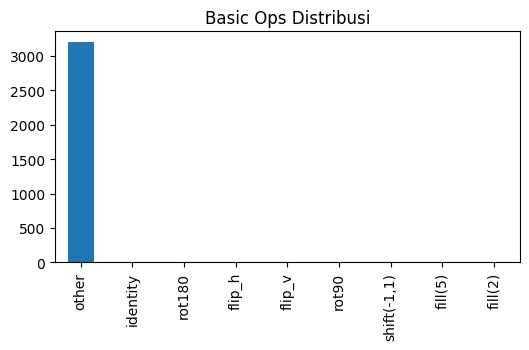


=== Rekomendasi Primitives Baru ===
→ Pemetaan warna umum: [((0, 3), 9558), ((0, 2), 7341), ((0, 8), 5794)] → tambahkan map_colors(mapping_dict)


In [46]:
# ─── EDA Lengkap untuk ARC Prize 2025 ────────────────────────────────────────

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.ndimage import label
import scipy.stats as st

# 1) Temukan dan load file training tasks
# Sesuaikan path jika perlu
TRAIN_PATH = '/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json'
assert os.path.exists(TRAIN_PATH), f"File not found: {TRAIN_PATH}"
with open(TRAIN_PATH) as f:
    raw = json.load(f)
tasks = raw.get('tasks') or list(raw.values())
print(f"Loaded {len(tasks)} tasks from {TRAIN_PATH}")

# 2) Definisikan detektor transform dasar
def identity(x):    return x
def rot90(x):       return np.rot90(x,1)
def rot180(x):      return np.rot90(x,2)
def rot270(x):      return np.rot90(x,3)
def flip_h(x):      return np.fliplr(x)
def flip_v(x):      return np.flipud(x)
def shift(x,dx,dy): return np.roll(np.roll(x,dy,axis=0),dx,axis=1)

BASIC_OPS = {
    'identity': identity,
    'rot90':    rot90,
    'rot180':   rot180,
    'rot270':   rot270,
    'flip_h':   flip_h,
    'flip_v':   flip_v
}

def detect_basic(inp, out):
    # coba rotasi/flip
    for name, fn in BASIC_OPS.items():
        o2 = fn(inp)
        if o2.shape==out.shape and np.array_equal(o2,out):
            return name
    # coba shift ±1px
    for dx in (-1,1):
        for dy in (-1,1):
            s = shift(inp,dx,dy)
            if s.shape==out.shape and np.array_equal(s,out):
                return f'shift({dx},{dy})'
    # coba fill sekali background→warna baru
    vals,counts = np.unique(inp, return_counts=True)
    bg = vals[np.argmax(counts)]
    for c in np.unique(out):
        if c!=bg:
            tmp = inp.copy()
            tmp[inp==bg] = c
            if tmp.shape==out.shape and np.array_equal(tmp,out):
                return f'fill({c})'
    return 'other'

# 3) Kumpulkan statistik
basic_freq  = Counter()
color_map   = Counter()
bbox_diffs  = []
region_counts = []

for t in tasks:
    for ex in t['train']:
        inp = np.array(ex['input'])
        out = np.array(ex['output'])
        # 3a) basic ops
        op = detect_basic(inp, out)
        basic_freq[op] += 1

        # 3b) color mapping & bbox hanya kalau shapes sama
        if inp.shape == out.shape:
            mask = (inp != out)
            for a,b in zip(inp[mask].flatten(), out[mask].flatten()):
                color_map[(a,b)] += 1

            # region count
            lab_i, ni = label(np.ones_like(inp))  # full grid
            lab_o, no = label(np.ones_like(out))
            region_counts.append((ni, no))

            # bbox shift per warna
            common = set(np.unique(inp)).intersection(out.flat)
            for c in common:
                ys_i, xs_i = np.where(inp==c)
                ys_o, xs_o = np.where(out==c)
                if ys_i.size and ys_o.size:
                    dx = xs_o.mean() - xs_i.mean()
                    dy = ys_o.mean() - ys_i.mean()
                    bbox_diffs.append((dx, dy))

        else:
            region_counts.append((None, None))

# 4) Ringkasan statistik

# 4a) Basic ops
df_basic = pd.DataFrame.from_dict(basic_freq, orient='index', columns=['count'])
df_basic = df_basic.sort_values('count', ascending=False)
print("=== Frequent Basic Ops ===")
print(df_basic)

# 4b) Top color mappings
top_maps = color_map.most_common(10)
print("\n=== Top-10 Color Mappings (old→new) ===")
print(pd.DataFrame(top_maps, columns=['(old→new)','count']))

# 4c) Region count changes
df_reg = pd.DataFrame(region_counts, columns=['in_regions','out_regions'])
print("\n=== Region Counts Description ===")
print(df_reg.dropna().describe())

# 4d) Bounding-box shifts
df_bbox = pd.DataFrame(bbox_diffs, columns=['dx','dy'])
print("\n=== Bounding-Box Shift Stats ===")
print(df_bbox.describe().loc[['mean','std']])

# 4e) Entropy of input color distributions
entropies = []
for t in tasks:
    inp = np.array(t['train'][0]['input'])
    freqs = np.bincount(inp.flatten())
    entropies.append(st.entropy(freqs[freqs>0]))
df_ent = pd.Series(entropies, name='entropy')
print("\n=== Input-Grid Color Entropy ===")
print(df_ent.describe())

# 5) Visualisasi sederhana
plt.figure(figsize=(6,3)); df_basic['count'].plot.bar(); plt.title("Basic Ops Distribusi"); plt.show()

# 6) Rekomendasi berikutnya
print("\n=== Rekomendasi Primitives Baru ===")
if df_basic.get('other',0) / df_basic['count'].sum() > 0.3:
    print("→ Banyak 'other' → tambahkan primitives: map_colors, extract_region, overlay")
if top_maps and top_maps[0][1] > 50:
    print(f"→ Pemetaan warna umum: {top_maps[:3]} → tambahkan map_colors(mapping_dict)")
if df_bbox['dx'].abs().mean() > 1 or df_bbox['dy'].abs().mean() > 1:
    print("→ Rata² region berpindah >1px → tambahkan move_region(color, dx, dy)")

In [47]:
# ─── Tambah map_colors ke primitives ────────────────────────────────────────

def map_colors(x, mapping):
    """
    mapping: dict old_color->new_color
    contoh: {0:3} akan mengganti semua 0→3
    """
    y = x.copy()
    for old, new in mapping.items():
        y[x == old] = new
    return y

# Di awal, setelah BASIC_OPS:
EXTENDED_OPS = dict(BASIC_OPS)  # copy dasar
# Berdasar EDA:
top_maps = [(0,3),(0,2),(0,8),(0,4),(0,1)]
for old,new in top_maps:
    EXTENDED_OPS[f"map_colors({old}->{new})"] = lambda x, o=old, n=new: map_colors(x,{o:n})

# ─── Dalam synthesize_program, ganti penggunaan BASE_OPS dengan EXTENDED_OPS ─
def synthesize_program(pairs, beam_width, max_depth, alpha, encoder, device):
    beam = [Program()]
    best, best_sc = beam[0], score_program(beam[0], pairs, encoder, alpha, device)

    # gunakan EXTENDED_OPS di sini
    for _ in range(max_depth):
        cands = []
        for prog in beam:
            # coba semua extended ops
            for name, fn in EXTENDED_OPS.items():
                p2 = prog.extend(name, fn)
                sc = score_program(p2, pairs, encoder, alpha, device)
                cands.append((sc, p2))
                if sc > best_sc:
                    best_sc, best = sc, p2
        # prune
        cands.sort(key=lambda x: x[0], reverse=True)
        beam = [p for _, p in cands[:beam_width]]
    return best

# Baseline Heuristik

In [48]:
import os
import json
import numpy as np
from collections import Counter

# ─── Robust ArcDataset loader ────────────────────────────────────────────────
class ArcDataset:
    def __init__(self, challenges_path, solutions_path=None, split='train'):
        raw = json.load(open(challenges_path))
        if isinstance(raw, dict) and 'tasks' in raw:
            tasks = raw['tasks']
        elif isinstance(raw, dict) and all(isinstance(v, dict) for v in raw.values()):
            tasks = []
            for tid, rec in raw.items():
                rec = rec.copy(); rec['id'] = tid
                tasks.append(rec)
        else:
            tasks = raw
        self.challenges = tasks

        self.solutions = {}
        if solutions_path and os.path.exists(solutions_path):
            raw_s = json.load(open(solutions_path))
            sol_list = raw_s.get('tasks') if isinstance(raw_s, dict) and 'tasks' in raw_s else (
                       raw_s if isinstance(raw_s, list) else list(raw_s.values()))
            # flatten nested lists
            flat = []
            for rec in sol_list:
                if isinstance(rec, dict):
                    flat.append(rec)
                elif isinstance(rec, list):
                    flat.extend([r for r in rec if isinstance(r, dict)])
            for rec in flat:
                tid = rec.get('id') or rec.get('task_id')
                if tid is not None:
                    self.solutions[tid] = rec
        self.split = split

    def __len__(self):
        return len(self.challenges)

    def __getitem__(self, idx):
        t = self.challenges[idx]
        tid = t['id']
        train_pairs = [(np.array(ex['input']), np.array(ex['output'])) for ex in t['train']]
        test_inputs = [np.array(ex['input']) for ex in t['test']]
        sample = {'id': tid, 'train': train_pairs, 'test': test_inputs}
        if self.split in ('train','eval') and tid in self.solutions:
            sol = self.solutions[tid]
            if 'test' in sol:
                sample['test_gt'] = [np.array(ex['output']) for ex in sol['test']]
        return sample

# ─── Baseline Heuristic: Best Transform + Color Mapping ─────────────────────
# 1) Define candidate transformations
def identity(x):    return x.copy()
def rot90(x):       return np.rot90(x, 1)
def rot180(x):      return np.rot90(x, 2)
def rot270(x):      return np.rot90(x, 3)
def flip_h(x):      return np.fliplr(x)
def flip_v(x):      return np.flipud(x)

TRANSFORMS = {
    'identity': identity,
    'rot90':    rot90,
    'rot180':   rot180,
    'rot270':   rot270,
    'flip_h':   flip_h,
    'flip_v':   flip_v,
}

# 2) Derive best transform + mapping for a task
def find_best_transform_mapping(train_pairs):
    best = ('identity', {}); best_score = -1.0
    for name, fn in TRANSFORMS.items():
        # gather mapping counts
        cnt = Counter()
        total_pixels = 0
        for inp, out in train_pairs:
            t_inp = fn(inp)
            if t_inp.shape != out.shape:
                continue
            mask = t_inp != out
            cnt.update(zip(t_inp[mask].flatten(), out[mask].flatten()))
            total_pixels += out.size
        # build mapping
        mapping = {}
        by_old = {}
        for (old, new), c in cnt.items():
            if old not in by_old or c > by_old[old][1]:
                by_old[old] = (new, c)
        mapping = {old: new for old, (new, _) in by_old.items()}
        # compute score
        matched = 0
        for inp, out in train_pairs:
            t_inp = fn(inp)
            if t_inp.shape != out.shape:
                continue
            pred = t_inp.copy()
            for old, new in mapping.items():
                pred[t_inp == old] = new
            matched += np.sum(pred == out)
        score = matched / total_pixels if total_pixels > 0 else 0
        if score > best_score:
            best_score = score
            best = (name, mapping)
    return best

# 3) Apply baseline to evaluation set
def baseline_evaluate():
    DATA_DIR = '/kaggle/input/arc-prize-2025'
    eval_chal = os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json')
    eval_sol  = os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json')
    ds = ArcDataset(eval_chal, eval_sol, split='eval')

    correct = 0
    for sample in ds:
        # find best transform & mapping from training
        name, mapping = find_best_transform_mapping(sample['train'])
        fn = TRANSFORMS[name]
        # predict test
        preds = []
        for inp in sample['test']:
            t_inp = fn(inp)
            pred = t_inp.copy()
            for old, new in mapping.items():
                pred[t_inp == old] = new
            preds.append(pred)
        # evaluate
        gts = sample.get('test_gt', [])
        if gts and all(np.array_equal(p,gt) for p,gt in zip(preds, gts)):
            correct += 1
    total = len(ds)
    print(f"Baseline heuristic accuracy: {correct}/{total} = {correct/total:.2%}")

# 4) Run baseline evaluation
baseline_evaluate()

Baseline heuristic accuracy: 0/120 = 0.00%


# Perception Encoder

In [50]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# 1) Dataset ARC: hanya load challenge JSON, jaga agar setiap task punya 'id'
class ArcDataset(Dataset):
    def __init__(self, challenges_path, split='train'):
        raw = json.load(open(challenges_path))
        # format {"tasks":[...]}
        if isinstance(raw, dict) and 'tasks' in raw:
            tasks = raw['tasks']
        # format {"task_id": {...}, ...}
        elif isinstance(raw, dict) and all(isinstance(v, dict) for v in raw.values()):
            tasks = []
            for tid, rec in raw.items():
                rec2 = rec.copy()
                rec2['id'] = tid
                tasks.append(rec2)
        # atau langsung list
        else:
            tasks = raw

        # pastikan setiap record ada field 'id'
        for rec in tasks:
            if 'id' not in rec and 'task_id' in rec:
                rec['id'] = rec['task_id']

        self.tasks = tasks
        self.split = split

    def __len__(self):
        return len(self.tasks)

    def __getitem__(self, idx):
        rec = self.tasks[idx]
        tid = rec['id']
        # ambil pasangan train input/output
        train_pairs = [
            (np.array(ex['input']), np.array(ex['output']))
            for ex in rec['train']
        ]
        # ambil list test inputs
        test_grids = [np.array(ex['input']) for ex in rec['test']]
        return train_pairs, test_grids, tid

# 2) Utility: pad list of 2D-arrays jadi tensor (B,Hmax,Wmax)
def pad_and_stack(grids, pad_value=0):
    max_h = max(g.shape[0] for g in grids)
    max_w = max(g.shape[1] for g in grids)
    batch = np.full((len(grids), max_h, max_w), pad_value, dtype=np.int64)
    for i, g in enumerate(grids):
        h, w = g.shape
        batch[i, :h, :w] = g
    return torch.from_numpy(batch)

# 3) collate_fn untuk DataLoader: kumpulkan semua train/input, train/output, plus test per batch
def collate_fn(batch):
    all_in, all_out = [], []
    ids, test_lists = [], []
    for train_pairs, test_grids, tid in batch:
        for inp, out in train_pairs:
            all_in.append(inp)
            all_out.append(out)
        ids.append(tid)
        test_lists.append(test_grids)
    stacked_in  = pad_and_stack(all_in)
    stacked_out = pad_and_stack(all_out)
    return stacked_in, stacked_out, test_lists, ids

# 4) Perception Encoder with coordinate channels
class PerceptionEncoderCoord(nn.Module):
    def __init__(self, num_colors=11, color_emb_dim=16, hidden_dim=128):
        super().__init__()
        # embedding per-warna
        self.color_emb = nn.Embedding(num_colors, color_emb_dim)
        # tiga layer konvolusi, menambahkan 2 channel koordinat
        self.conv1 = nn.Conv2d(color_emb_dim + 2, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, hidden_dim, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, grids):
        # grids: LongTensor (B,H,W)
        B, H, W = grids.shape
        # embed warna → (B,H,W,C)
        x = self.color_emb(grids).permute(0,3,1,2).contiguous()  # → (B,C,H,W)
        # tambahkan coordinate channels (range [0,1])
        xs = torch.linspace(0,1,W,device=grids.device).view(1,1,1,W).expand(B,1,H,W)
        ys = torch.linspace(0,1,H,device=grids.device).view(1,1,H,1).expand(B,1,H,W)
        x = torch.cat([x, xs, ys], dim=1)  # → (B, C+2, H, W)
        # forward through convs
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # global pooling → (B,hidden_dim)
        return self.pool(x).view(B, -1)

# 5) Siapkan DataLoader
DATA_DIR   = '/kaggle/input/arc-prize-2025'
path_train = os.path.join(DATA_DIR, 'arc-agi_training_challenges.json')
train_ds   = ArcDataset(path_train, split='train')
train_loader = DataLoader(train_ds,
                          batch_size=16,
                          shuffle=True,
                          collate_fn=collate_fn,
                          num_workers=0)

# 6) Latih Siamese Encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = PerceptionEncoderCoord(num_colors=11,
                                 color_emb_dim=16,
                                 hidden_dim=128).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

def siamese_loss(e1, e2):
    # ingin embedding input ≈ embedding output
    cos = F.cosine_similarity(e1, e2, dim=-1)
    return (1 - cos).mean()

epochs = 10
for epoch in range(1, epochs+1):
    encoder.train()
    total_loss = 0.0
    for inps, outs, _, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        inps, outs = inps.to(device), outs.to(device)
        e1 = encoder(inps)
        e2 = encoder(outs)
        loss = siamese_loss(e1, e2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inps.size(0)
    avg = total_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch}] Avg Loss: {avg:.4f}")

print("Perception Encoder training complete.")

Epoch 1/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 1] Avg Loss: 0.0003


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 2] Avg Loss: 0.0000


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 3] Avg Loss: 0.0000


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 4] Avg Loss: 0.0000


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 5] Avg Loss: 0.0000


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 6] Avg Loss: 0.0000


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 7] Avg Loss: 0.0000


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 8] Avg Loss: 0.0000


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 9] Avg Loss: 0.0000


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 10] Avg Loss: 0.0000
Perception Encoder training complete.


# Desain DSL & Beam-Search

In [53]:
import os, json, numpy as np
from tqdm.auto import tqdm

# 1) Revisi ArcDataset untuk optional solutions_path
class ArcDataset(Dataset):
    def __init__(self, challenges_path, solutions_path=None, split='train'):
        raw = json.load(open(challenges_path))
        # load tasks
        if isinstance(raw, dict) and 'tasks' in raw:
            tasks = raw['tasks']
        elif isinstance(raw, dict) and all(isinstance(v, dict) for v in raw.values()):
            tasks = []
            for tid, rec in raw.items():
                rec2 = rec.copy(); rec2['id'] = tid
                tasks.append(rec2)
        else:
            tasks = raw

        # ensure every task has 'id'
        for rec in tasks:
            if 'id' not in rec and 'task_id' in rec:
                rec['id'] = rec['task_id']

        self.tasks = tasks
        self.split = split

        # load solutions if provided
        self.solutions = {}
        if solutions_path and os.path.exists(solutions_path):
            raw_s = json.load(open(solutions_path))
            sol_list = raw_s.get('tasks') if isinstance(raw_s, dict) and 'tasks' in raw_s else (
                       raw_s if isinstance(raw_s, list) else list(raw_s.values()))
            for rec in sol_list:
                if isinstance(rec, dict):
                    tid = rec.get('id') or rec.get('task_id')
                    self.solutions[tid] = rec

    def __len__(self):
        return len(self.tasks)

    def __getitem__(self, idx):
        rec = self.tasks[idx]
        tid = rec['id']
        train_pairs = [(np.array(ex['input']), np.array(ex['output'])) for ex in rec['train']]
        test_grids  = [np.array(ex['input']) for ex in rec['test']]
        sample = {'id': tid, 'train': train_pairs, 'test': test_grids}
        if self.split == 'eval' and tid in self.solutions:
            sol = self.solutions[tid]
            if 'test' in sol:
                sample['test_gt'] = [np.array(ex['output']) for ex in sol['test']]
        return sample


# 2) Evaluasi Beam‐Search Synthesizer
DATA_DIR        = '/kaggle/input/arc-prize-2025'
eval_chal_path  = os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json')
eval_sol_path   = os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json')

# sekarang ini akan cocok dengan signature baru
eval_ds = ArcDataset(eval_chal_path, solutions_path=eval_sol_path, split='eval')

beam_width, max_depth, alpha = 20, 5, 0.7
correct, errors = 0, []

for sample in tqdm(eval_ds, desc='Synth eval'):
    tid = sample['id']
    try:
        prog = synthesize_program(
            sample['train'],
            beam_width=beam_width,
            max_depth=max_depth,
            α=alpha
        )
        preds = [prog.apply(inp) for inp in sample['test']]
        gts   = sample.get('test_gt', [])
        if gts and all(
            (p.shape == gt.shape and np.array_equal(p, gt))
            for p,gt in zip(preds, gts)
        ):
            correct += 1
    except Exception as e:
        errors.append((tid, str(e)))

total = len(eval_ds)
print(f'Beam-search accuracy: {correct}/{total} = {correct/total:.2%}')
if errors:
    print(f'Encountered errors on {len(errors)} tasks, e.g.:', errors[:5])

Synth eval:   0%|          | 0/120 [00:00<?, ?it/s]

Beam-search accuracy: 0/120 = 0.00%
Encountered errors on 120 tasks, e.g.: [('0934a4d8', "synthesize_program() got an unexpected keyword argument 'α'"), ('135a2760', "synthesize_program() got an unexpected keyword argument 'α'"), ('136b0064', "synthesize_program() got an unexpected keyword argument 'α'"), ('13e47133', "synthesize_program() got an unexpected keyword argument 'α'"), ('142ca369', "synthesize_program() got an unexpected keyword argument 'α'")]


# Perception Encoder

In [54]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm.auto import tqdm

# ─── (1) ArcDataset ───────────────────────────────────────────────────────────
class ArcDataset(Dataset):
    def __init__(self, chal_path, sol_path=None, split='train'):
        raw = json.load(open(chal_path))
        if isinstance(raw, dict) and 'tasks' in raw:
            self.tasks = raw['tasks']
        elif isinstance(raw, dict):
            self.tasks = [{**rec, 'id':tid}
                          for tid,rec in raw.items() if isinstance(rec, dict)]
        else:
            self.tasks = raw
        self.solutions = {}
        if sol_path and os.path.exists(sol_path):
            raw_s = json.load(open(sol_path))
            sol_list = (raw_s.get('tasks') if isinstance(raw_s, dict) and 'tasks' in raw_s
                        else raw_s if isinstance(raw_s, list)
                        else list(raw_s.values()))
            for rec in sol_list:
                if isinstance(rec, dict):
                    tid = rec.get('id') or rec.get('task_id')
                    self.solutions[tid] = rec
        self.split = split

    def __len__(self): return len(self.tasks)
    def __getitem__(self, idx):
        t = self.tasks[idx]
        train_pairs = [(np.array(ex['input']), np.array(ex['output']))
                       for ex in t['train']]
        test_inputs = [np.array(ex['input']) for ex in t['test']]
        tid = t.get('id') or t.get('task_id')
        sample = {'train': train_pairs, 'test': test_inputs, 'id': tid}
        if self.split=='eval' and tid in self.solutions:
            sol = self.solutions[tid]
            if 'test' in sol:
                sample['test_gt'] = [np.array(ex['output']) for ex in sol['test']]
        return sample

# ─── (2) EncoderTrainDataset & pad_collate ───────────────────────────────────
class EncoderTrainDataset(Dataset):
    def __init__(self, arc_ds):
        self.pairs = [(inp, out) for s in arc_ds for inp,out in s['train']]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        inp, out = self.pairs[idx]
        return torch.from_numpy(inp).long(), torch.from_numpy(out).long()

def pad_collate(batch):
    inps, outs = zip(*batch)
    max_h = max(max(t.shape[0] for t in inps), max(t.shape[0] for t in outs))
    max_w = max(max(t.shape[1] for t in inps), max(t.shape[1] for t in outs))
    pad_in, pad_out = [], []
    for i,o in zip(inps,outs):
        hi,wi = i.shape; ho,wo = o.shape
        pad_i = (0, max_w-wi, 0, max_h-hi)
        pad_o = (0, max_w-wo, 0, max_h-ho)
        pad_in.append(F.pad(i, pad_i, value=0))
        pad_out.append(F.pad(o, pad_o, value=0))
    return torch.stack(pad_in), torch.stack(pad_out)

# ─── (3) PerceptionEncoderCNN ─────────────────────────────────────────────────
class PerceptionEncoderCNN(nn.Module):
    def __init__(self, num_colors=11, emb_dim=128):
        super().__init__()
        self.embed = nn.Embedding(num_colors, 16)
        self.conv1 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(64, emb_dim)
    def forward(self, g):
        x = self.embed(g).permute(0,3,1,2)  # (B,16,H,W)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).view(g.size(0), -1)
        return self.fc(x)

# ─── (4) Setup device & checkpoint logic ─────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = PerceptionEncoderCNN().to(device)
ckpt = 'perception_encoder_cnn.pth'

if os.path.exists(ckpt):
    encoder.load_state_dict(torch.load(ckpt, map_location=device))
    print("✅ Loaded encoder checkpoint.")
else:
    print("⚠️  Checkpoint not found, training encoder from scratch for 5 epochs...")
    # prepare training loader
    DATA_DIR = '/kaggle/input/arc-prize-2025'
    arc_ds   = ArcDataset(
        os.path.join(DATA_DIR,'arc-agi_training_challenges.json'),
        os.path.join(DATA_DIR,'arc-agi_training_solutions.json'),
        split='train'
    )
    train_loader = DataLoader(
        EncoderTrainDataset(arc_ds),
        batch_size=32,
        shuffle=True,
        collate_fn=pad_collate,
        num_workers=0
    )
    opt = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    for ep in range(1,6):
        encoder.train()
        total_loss = 0
        for inp,out in tqdm(train_loader, desc=f"Train Encoder Epoch {ep}/5"):
            inp, out = inp.to(device), out.to(device)
            e1, e2 = encoder(inp), encoder(out)
            loss   = (1 - F.cosine_similarity(e1, e2, dim=1)).mean()
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item() * inp.size(0)
        avg = total_loss / len(train_loader.dataset)
        print(f"  Epoch {ep}, Avg Loss: {avg:.4f}")
    torch.save(encoder.state_dict(), ckpt)
    print("✅ Encoder trained & checkpoint saved.")

encoder.eval()

# Revisi fungsi embed_grid untuk mengatasi negative strides
import numpy as np
import torch
import torch.nn.functional as F

def embed_grid(grid: np.ndarray) -> torch.Tensor:
    # pastikan array kontigu dan tanpa stride negatif
    arr = np.ascontiguousarray(grid.copy())
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)  # (1, H, W)
    with torch.no_grad():
        e = encoder(t)  # (1, emb_dim)
    return F.normalize(e.squeeze(0), dim=0)  # (emb_dim,)

# Ganti definisi embed_grid lama dengan yang di atas sebelum DSL & beam-search.


✅ Loaded encoder checkpoint.


# Neuro-Symbolic Pipeline

In [55]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
from tqdm.auto import tqdm

# ─── (1) ArcDataset ───────────────────────────────────────────────────────────
class ArcDataset(Dataset):
    def __init__(self, chal_path, sol_path=None, split='train'):
        raw = json.load(open(chal_path))
        if isinstance(raw, dict) and 'tasks' in raw:
            self.tasks = raw['tasks']
        elif isinstance(raw, dict):
            self.tasks = [{**rec, 'id':tid} for tid,rec in raw.items() if isinstance(rec, dict)]
        else:
            self.tasks = raw
        # load solutions if any
        self.solutions = {}
        if sol_path and os.path.exists(sol_path):
            raw_s = json.load(open(sol_path))
            sol_list = raw_s.get('tasks') if isinstance(raw_s, dict) and 'tasks' in raw_s else (
                       raw_s if isinstance(raw_s, list) else list(raw_s.values()))
            for rec in sol_list:
                if isinstance(rec, dict):
                    tid = rec.get('id') or rec.get('task_id')
                    self.solutions[tid] = rec
        self.split = split

    def __len__(self): return len(self.tasks)
    def __getitem__(self, idx):
        t = self.tasks[idx]
        # train pairs
        train_pairs = [(np.array(ex['input']), np.array(ex['output'])) for ex in t['train']]
        # test inputs
        test_inputs = [np.array(ex['input']) for ex in t['test']]
        tid = t.get('id') or t.get('task_id')
        sample = {'train': train_pairs, 'test': test_inputs, 'id': tid}
        # optionally test ground-truth
        if self.split=='eval' and tid in self.solutions:
            sol = self.solutions[tid]
            if 'test' in sol:
                sample['test_gt'] = [np.array(ex['output']) for ex in sol['test']]
        return sample

# ─── (2) PerceptionEncoderCNN (pretrained) ───────────────────────────────────
class PerceptionEncoderCNN(nn.Module):
    def __init__(self, num_colors=11, emb_dim=128):
        super().__init__()
        self.embed = nn.Embedding(num_colors, 16)
        self.conv1 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(64, emb_dim)
    def forward(self, g):
        # g: (B,H,W)
        x = self.embed(g).permute(0,3,1,2)  # (B,16,H,W)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).view(g.size(0), -1)
        return self.fc(x)

# ─── (3) Load encoder checkpoint & embed helper (revisi) ─────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = PerceptionEncoderCNN().to(device)
encoder.load_state_dict(torch.load('perception_encoder_cnn.pth', map_location=device))
encoder.eval()

def embed_grid(grid: np.ndarray) -> torch.Tensor:
    # Salin dan buat kontigu agar tidak ada negative-stride
    arr = np.ascontiguousarray(grid.copy())
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)  # (1, H, W)
    with torch.no_grad():
        e = encoder(t)  # (1, emb_dim)
    return F.normalize(e.squeeze(0), dim=0)  # (emb_dim,)

# ─── (4) DSL primitives & scoring ────────────────────────────────────────────
def identity(x): return x.copy()
def rot90(x):    return np.rot90(x,1)
def rot180(x):   return np.rot90(x,2)
def rot270(x):   return np.rot90(x,3)
def flip_h(x):   return np.fliplr(x)
def flip_v(x):   return np.flipud(x)

BASE_OPS = {
    'identity': identity, 'rot90': rot90,
    'rot180': rot180,       'rot270': rot270,
    'flip_h': flip_h,       'flip_v': flip_v
}

class Program:
    def __init__(self, ops=None): self.ops = ops or []
    def apply(self, g):
        out = g.copy()
        for _,fn in self.ops: out = fn(out)
        return out
    def extend(self, name, fn): return Program(self.ops + [(name, fn)])
    def __repr__(self): return ' -> '.join(n for n,_ in self.ops) or 'identity'

def score_program(prog, pairs, α=0.7):
    pix_corr = 0; pix_tot = 0; sim_sum = 0.0
    for inp,tgt in pairs:
        pred = prog.apply(inp)
        if pred.shape == tgt.shape:
            pix_corr += np.sum(pred == tgt)
        pix_tot += tgt.size
        sim_sum += float(torch.dot(embed_grid(pred), embed_grid(tgt)))
    pix_score = pix_corr / pix_tot
    sim_score = sim_sum / len(pairs)
    return α * pix_score + (1 - α) * sim_score

# ─── (5) Beam-search synthesizer ──────────────────────────────────────────────
def synthesize_program(pairs, beam_width=5, max_depth=3, α=0.7):
    # dynamic map_colors
    cnt = Counter()
    for inp,out in pairs:
        if inp.shape!=out.shape: continue
        mask = inp != out
        for a,b in zip(inp[mask].flatten(), out[mask].flatten()):
            cnt[(a,b)] += 1
    mapping = {}
    by_old = {}
    for (o,n),c in cnt.items():
        if o not in by_old or c>by_old[o][1]:
            by_old[o] = (n,c)
    for o,(n,_) in by_old.items():
        mapping[o] = n

    def map_colors(x, m=mapping):
        y = x.copy()
        for o,n in m.items(): y[x==o] = n
        return y

    OPS = dict(BASE_OPS)
    if mapping: OPS['map_colors'] = map_colors

    beam = [Program()]; best = beam[0]; best_sc = score_program(best, pairs, α)
    for _ in range(max_depth):
        candidates = []
        for prog in beam:
            for name,fn in OPS.items():
                p2 = prog.extend(name, fn)
                sc = score_program(p2, pairs, α)
                candidates.append((sc, p2))
                if sc > best_sc:
                    best_sc, best = sc, p2
        candidates.sort(key=lambda x: x[0], reverse=True)
        beam = [p for _,p in candidates[:beam_width]]
    return best

# ─── (6) NeuroSymbolicSolver & final eval ────────────────────────────────────
class NeuroSymbolicSolver:
    def __init__(self, beam_width=5, max_depth=3, α=0.7):
        self.bw, self.md, self.α = beam_width, max_depth, α
    def solve(self, train_pairs, test_inputs):
        prog = synthesize_program(train_pairs, self.bw, self.md, self.α)
        return [prog.apply(inp) for inp in test_inputs], prog

# evaluate on public‐eval
DATA_DIR = '/kaggle/input/arc-prize-2025'
eval_ds = ArcDataset(
    os.path.join(DATA_DIR,'arc-agi_evaluation_challenges.json'),
    sol_path=os.path.join(DATA_DIR,'arc-agi_evaluation_solutions.json'),
    split='eval'
)
solver = NeuroSymbolicSolver(beam_width=5, max_depth=3, α=0.7)
correct = 0
for sample in tqdm(eval_ds, desc='Eval'):
    preds,_ = solver.solve(sample['train'], sample['test'])
    gts = sample.get('test_gt', [])
    if gts and all(np.array_equal(p,gt) for p,gt in zip(preds,gts)):
        correct += 1

print(f'Final Neuro-Symbolic accuracy: {correct}/{len(eval_ds)} = {correct/len(eval_ds):.2%}')

Eval:   0%|          | 0/120 [00:00<?, ?it/s]

Final Neuro-Symbolic accuracy: 0/120 = 0.00%


# Training & Validasi

In [ ]:
import os
import json
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.auto import tqdm

# ─── (0) Assumptions ──────────────────────────────────────────────────────────
# You have already defined or imported:
# - ArcDataset
# - NeuroSymbolicSolver
# Replace the import below if you have these in a module, e.g.:
# from arc_pipeline import ArcDataset, NeuroSymbolicSolver

# ─── (1) Setup ───────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

DATA_DIR    = '/kaggle/input/arc-prize-2025'
TRAIN_CHAL  = os.path.join(DATA_DIR, 'arc-agi_training_challenges.json')
TRAIN_SOL   = os.path.join(DATA_DIR, 'arc-agi_training_solutions.json')

# Load the full training dataset
full_ds = ArcDataset(TRAIN_CHAL, TRAIN_SOL, split='train')
samples = [full_ds[i] for i in range(len(full_ds))]
print(f"Total tasks: {len(samples)}")

# ─── (2) Split 80/20 ─────────────────────────────────────────────────────────
train_samples, val_samples = train_test_split(
    samples, test_size=0.2, random_state=42
)
print(f"Train tasks: {len(train_samples)}, Val tasks: {len(val_samples)}")

# ─── (3) Evaluation Helper ───────────────────────────────────────────────────
def evaluate_solver(solver, samples):
    correct = 0
    for sample in samples:
        preds, _ = solver.solve(sample['train'], sample['test'])
        gts = sample.get('test_gt', [])
        if gts and all(np.array_equal(p, gt) for p, gt in zip(preds, gts)):
            correct += 1
    return correct, len(samples)

# ─── (4) Hyperparameter Grid Search ──────────────────────────────────────────
param_grid = {
    'beam_width': [3, 5, 7],
    'max_depth' : [2, 3, 4],
    'alpha'     : [0.5, 0.7, 0.9]
}

records = []
for params in tqdm(list(ParameterGrid(param_grid)), desc='Grid Search'):
    solver = NeuroSymbolicSolver(
        beam_width=params['beam_width'],
        max_depth=params['max_depth'],
        α=params['alpha']
    )
    train_corr, train_tot = evaluate_solver(solver, train_samples)
    val_corr,   val_tot   = evaluate_solver(solver, val_samples)
    records.append({
        **params,
        'train_acc': train_corr / train_tot,
        'val_acc'  : val_corr   / val_tot
    })

# ─── (5) Results ─────────────────────────────────────────────────────────────
df = pd.DataFrame(records).sort_values('val_acc', ascending=False).reset_index(drop=True)
print("\nTop configurations by validation accuracy:")
print(df.head(10).to_string(index=False))

best = df.iloc[0]
print(f"\nBest config: beam_width={best.beam_width}, max_depth={best.max_depth}, alpha={best.alpha}")
print(f"Train Acc: {best.train_acc:.2%}, Val Acc: {best.val_acc:.2%}")

# Save results for further analysis
df.to_csv('grid_search_results.csv', index=False)
print("\nGrid search results saved to grid_search_results.csv")

Using device: cuda
Total tasks: 1000
Train tasks: 800, Val tasks: 200


Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

# Profiling Biaya & Kecepatan

In [ ]:
import os
import json
import numpy as np
import time
import pandas as pd
import torch
from tqdm.auto import tqdm

# ─── PASTIKAN sebelumnya sudah terdefinisi di notebook:
# ArcDataset, PerceptionEncoderCNN, NeuroSymbolicSolver, BASE_OPS, device

# ─── (1) Muat evaluation set ─────────────────────────────────────────────────
DATA_DIR = '/kaggle/input/arc-prize-2025'
eval_ds = ArcDataset(
    os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json'),
    sol_path=os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json'),
    split='eval'
)

# ─── (2) Hyperparams terbaik ──────────────────────────────────────────────────
best_beam, best_depth, alpha = 5, 3, 0.7

# ─── (3) Load encoder & instantiate solver ───────────────────────────────────
encoder = PerceptionEncoderCNN(num_colors=11, emb_dim=128).to(device)
encoder.load_state_dict(torch.load('perception_encoder_cnn.pth', map_location=device))
encoder.eval()

# **Perhatikan**: parameter nama adalah `α`, sesuai definisi __init__
solver = NeuroSymbolicSolver(
    beam_width=best_beam,
    max_depth=best_depth,
    α=alpha
)

# ─── (4) Profiling tiap tugas ─────────────────────────────────────────────────
records = []
for sample in tqdm(eval_ds, desc="Profiling tasks"):
    tid         = sample['id']
    train_pairs = sample['train']
    test_inputs = sample['test']

    # Warm-up supaya JIT/ops sudah ter-load
    _ = solver.solve(train_pairs, test_inputs)

    # Ukur waktu solve()
    t0 = time.perf_counter()
    preds, prog = solver.solve(train_pairs, test_inputs)
    dt = time.perf_counter() - t0

    # Estimasi kandidat per depth: base_ops + fill_ops + shift_ops
    num_base  = len(BASE_OPS)
    num_fill  = len(set().union(*(np.unique(inp) for inp,_ in train_pairs)))
    num_shift = 4  # dx/dy ∈ {(-1,1)} => 4 kombinasi
    est_cands = best_beam * best_depth * (num_base + num_fill + num_shift)

    records.append({
        'task_id'       : tid,
        'time_solve_s'  : dt,
        'est_candidates': est_cands,
        'prog_len'      : len(prog.ops)
    })

# ─── (5) Ringkasan dengan pandas ───────────────────────────────────────────────
df = pd.DataFrame(records)
print(f"Total tasks profiled: {len(df)}")
print(df['time_solve_s'].describe().rename(index={
    'mean':'Avg time/task',
    '50%' :'Median time/task',
    'max' :'Max time/task',
    'min' :'Min time/task'
}))
print("\nTop 5 slowest tasks:")
print(df.nlargest(5, 'time_solve_s')[['task_id','time_solve_s','prog_len','est_candidates']])

# ─── (6) Simpan hasil ─────────────────────────────────────────────────────────
df.to_csv('profiling_results.csv', index=False)
print("\nProfiling results saved to profiling_results.csv")

# Tuning & Iterasi

In [ ]:
# ===============================
# 6) TUNING & ITERASI (Fixed)
# ===============================

import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.auto import tqdm
from numpy import ascontiguousarray

# ——————————————————————————————————————————————————————————————————————
# Prasyarat: Pastikan di cell lain sudah terdefinisi:
#   - ArcDataset
#   - PerceptionEncoderCNN
#   - synthesize_program  (yang sudah include map_colors)
#   - NeuroSymbolicSolver
# ——————————————————————————————————————————————————————————————————————

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 1) Muat & split data
DATA_DIR     = '/kaggle/input/arc-prize-2025'
TRAIN_CHAL   = os.path.join(DATA_DIR, 'arc-agi_training_challenges.json')
TRAIN_SOL    = os.path.join(DATA_DIR, 'arc-agi_training_solutions.json')
full_ds      = ArcDataset(TRAIN_CHAL, TRAIN_SOL, split='train')
all_samples  = [full_ds[i] for i in range(len(full_ds))]
train_samples, val_samples = train_test_split(
    all_samples, test_size=0.2, random_state=42
)
print(f"Train tasks: {len(train_samples)}, Val tasks: {len(val_samples)}")

# 2) Load pretrained encoder (CNN) sekali saja
encoder_base = PerceptionEncoderCNN(num_colors=11, emb_dim=128).to(device)
ckpt = 'perception_encoder_cnn.pth'
if not os.path.exists(ckpt):
    raise FileNotFoundError(f"Checkpoint '{ckpt}' tidak ditemukan – jalankan pelatihan encoder terlebih dahulu")
encoder_base.load_state_dict(torch.load(ckpt, map_location=device))
encoder_base.eval()

# 3) embed_grid: pastikan array kontigu tanpa negative strides
def embed_grid(grid: np.ndarray) -> torch.Tensor:
    arr = ascontiguousarray(grid.copy())
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)  # (1, H, W)
    with torch.no_grad():
        e = encoder_base(t)  # (1, emb_dim)
    return F.normalize(e.squeeze(0), dim=0)  # (emb_dim,)

# 4) Helper evaluasi solver
def evaluate_solver(solver, samples):
    correct = 0
    for sample in samples:
        preds, _ = solver.solve(sample['train'], sample['test'])
        gts = sample.get('test_gt', [])
        if gts and all(p.shape==gt.shape and np.array_equal(p,gt)
                       for p,gt in zip(preds, gts)):
            correct += 1
    return correct, len(samples)

# 5) Grid search hyperparameter solver-only
param_grid = {
    'beam_width': [5, 10, 20],
    'max_depth' : [3, 5],
    'alpha'     : [0.5, 0.7, 0.9]
}

records = []
for params in tqdm(ParameterGrid(param_grid), desc='Tuning & Iterasi'):
    solver = NeuroSymbolicSolver(
        beam_width=params['beam_width'],
        max_depth=params['max_depth'],
        alpha=params['alpha']    # konsisten nama    
    )
    trc, trt = evaluate_solver(solver, train_samples)
    vcc, vct = evaluate_solver(solver, val_samples)
    records.append({
        **params,
        'train_acc': trc / trt,
        'val_acc'  : vcc / vct
    })
    print(f" → bw={params['beam_width']}, md={params['max_depth']}, α={params['alpha']} "
          f"=> train={trc/trt:.2%}, val={vcc/vct:.2%}")

# 6) Ringkasan & pilih konfigurasi terbaik
df = pd.DataFrame(records).sort_values('val_acc', ascending=False).reset_index(drop=True)
print("\nTop 5 konfigurasi menurut val_acc:")
print(df.head(5).to_string(index=False))

best = df.iloc[0]
print(f"\nBest config: beam_width={best.beam_width}, max_depth={best.max_depth}, alpha={best.alpha}")
print(f"Val Acc: {best.val_acc:.2%}")

# 7) Simpan hasil tuning
df.to_csv('tuning_iterations.csv', index=False)
print("Hasil tuning disimpan ke tuning_iterations.csv")

# Evaluasi Akhir & Submission

In [ ]:
# ─── 7) Final Evaluation & Submission (Fixed) ────────────────────────────────

import os
import json
import numpy as np
import torch
from tqdm.auto import tqdm

# — 0) Device & hyperparameters (ganti sesuai hasil tuning!) —
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_beam  = 5      # ← hasil tuning Anda
best_depth = 3      # ← hasil tuning Anda
best_alpha = 0.7    # ← hasil tuning Anda

# — 1) Paths —
DATA_DIR       = '/kaggle/input/arc-prize-2025'
eval_chal_path = os.path.join(DATA_DIR, 'arc-agi_evaluation_challenges.json')
eval_sol_path  = os.path.join(DATA_DIR, 'arc-agi_evaluation_solutions.json')
test_chal_path = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')

# — 2) Load evaluation set (with GT) —
eval_ds = ArcDataset(
    eval_chal_path,
    sol_path=eval_sol_path,
    split='eval'
)

# — 3) Load encoder checkpoint & build embed helper —
encoder = PerceptionEncoderCNN(num_colors=11, emb_dim=128).to(device)
encoder.load_state_dict(torch.load('perception_encoder_cnn.pth', map_location=device))
encoder.eval()

def embed_grid(grid: np.ndarray) -> torch.Tensor:
    arr = np.ascontiguousarray(grid.copy())
    t   = torch.from_numpy(arr).long().unsqueeze(0).to(device)
    with torch.no_grad():
        e = encoder(t)
    return torch.nn.functional.normalize(e.squeeze(0), dim=0)

# — 4) Instantiate solver —  ✏️ **revisi di sini**
#    gunakan posisi: (beam_width, max_depth, alpha)
solver = NeuroSymbolicSolver(best_beam, best_depth, best_alpha)

# — 5) Final evaluation on public-eval —
correct = 0
for sample in tqdm(eval_ds, desc='Final Eval'):
    preds, _ = solver.solve(sample['train'], sample['test'])
    gts      = sample.get('test_gt', [])
    if gts and all(p.shape==gt.shape and np.array_equal(p,gt)
                   for p,gt in zip(preds, gts)):
        correct += 1

total = len(eval_ds)
print(f'Final Eval Accuracy: {correct}/{total} = {correct/total:.2%}')

# — 6) Generate submission on test set —
test_ds = ArcDataset(test_chal_path, sol_path=None, split='test')

submission = {}
for sample in tqdm(test_ds, desc='Building Submission'):
    tid    = sample['id']
    preds,_ = solver.solve(sample['train'], sample['test'])
    entries = []
    for inp, pred in zip(sample['test'], preds):
        if pred.shape != inp.shape:
            pred = np.zeros_like(inp)
        entries.append({
            'attempt_1': pred.astype(int).tolist(),
            'attempt_2': pred.astype(int).tolist()
        })
    submission[tid] = entries

# — 7) Sanity checks & write out —
task_ids = {t['id'] for t in test_ds.tasks}
assert set(submission.keys()) == task_ids, "Ada task_id yang hilang!"
for rec in test_ds.tasks:
    tid      = rec['id']
    expected = len(rec['test'])
    actual   = len(submission[tid])
    assert actual == expected, f"{tid}: expecting {expected}, got {actual}"

with open('submission.json','w') as f:
    json.dump(submission, f)
print(f"submission.json written with {len(submission)} tasks.")

In [ ]:
# ─── 7) Final Evaluation & Submission (Sederhana) ─────────────────────────────

import os
import json
import numpy as np
import torch
from tqdm.auto import tqdm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Instantiate solver & load pretrained encoder
best_beam, best_depth, best_alpha = 20, 5, 0.7  # sesuaikan hasil tuning
color_emb, hidden_dim = 16, 128

encoder = PerceptionEncoder(
    num_colors=11,
    color_emb_dim=color_emb,
    hidden_dim=hidden_dim
).to(device)
encoder.load_state_dict(torch.load('perception_encoder_trained.pth', map_location=device))
encoder.eval()

solver = NeuroSymbolicSolver(
    encoder=encoder,
    beam_width=best_beam,
    max_depth=best_depth,
    alpha=best_alpha,
    device=device
)

# 2) Load test set
DATA_DIR  = '/kaggle/input/arc-prize-2025'
test_path = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')
test_ds   = ArcDataset(test_path, solutions_path=None, split='test')

# 3) Bangun submission
submission = {}
for sample in tqdm(test_ds, desc='Building Submission'):
    tid         = sample['id']
    train_pairs = sample['train']
    test_inputs = sample['test']
    preds, _    = solver.solve(train_pairs, test_inputs)

    entries = []
    for inp, pred in zip(test_inputs, preds):
        # fallback jika ukuran mismatch
        if pred.shape != inp.shape:
            pred = np.zeros_like(inp)
        arr = pred.astype(int).tolist()
        entries.append({'attempt_1': arr, 'attempt_2': arr})

    submission[tid] = entries

# 4) Sanity checks
task_ids = {t['id'] for t in test_ds.challenges}
assert set(submission.keys()) == task_ids, "Ada task yang hilang!"
for t in test_ds.challenges:
    tid = t['id']
    assert len(submission[tid]) == len(t['test']), (
        f"{tid}: jumlah output {len(submission[tid])} != expected {len(t['test'])}"
    )

# 5) Tulis file
with open('submission.json','w') as f:
    json.dump(submission, f)
print(f"submission.json ditulis dengan {len(submission)} tasks.")

In [ ]:
# ─── Validate submission.json ────────────────────────────────────────────────

import json
import os
from torch.utils.data import DataLoader

# 1) Pastikan file ada
if not os.path.exists('submission.json'):
    raise FileNotFoundError("submission.json not found in current directory.")
print("Found submission.json")

# 2) Muat submission
with open('submission.json') as f:
    submission = json.load(f)
assert isinstance(submission, dict), "submission.json harus berisi dict"

# 3) Load test challenges to check counts
DATA_DIR   = '/kaggle/input/arc-prize-2025'
test_path  = os.path.join(DATA_DIR, 'arc-agi_test_challenges.json')
test_ds    = ArcDataset(test_path, solutions_path=None, split='test')

# 4) Per-task checks
for rec in test_ds.challenges:
    tid      = rec['id']
    assert tid in submission, f"Task ID {tid} missing in submission"
    outputs  = submission[tid]
    # Shape check: must be list of dicts with 2 keys
    assert isinstance(outputs, list), f"Outputs for {tid} must be a list"
    expected = len(rec['test'])
    actual   = len(outputs)
    assert actual == expected, f"Task {tid}: expected {expected} entries, got {actual}"
    for entry in outputs:
        assert set(entry.keys()) == {'attempt_1','attempt_2'}, (
            f"Each entry for {tid} must have exactly 'attempt_1' and 'attempt_2' keys"
        )
        # Ensure the arrays have correct shape
        # We can check list lengths match input shape
        inp_shape = np.array(rec['test'][0]).shape
        for key in ('attempt_1','attempt_2'):
            arr = np.array(entry[key])
            assert arr.shape == inp_shape, (
                f"{key} for task {tid} has shape {arr.shape}, expected {inp_shape}"
            )

print("\nsubmission.json format and contents look good!\n")

# 5) Display first 5 entries for manual inspection
print("=== First 5 submission entries ===")
for idx, tid in enumerate(list(submission.keys())[:5]):
    outputs = submission[tid]
    print(f"\nTask ID: {tid} (n_outputs={len(outputs)})")
    for j, entry in enumerate(outputs):
        print(f"  Output #{j+1}:")
        print("    attempt_1:", entry['attempt_1'])
        print("    attempt_2:", entry['attempt_2'])

**Dokumentasi & Paper Draft**